### CSCI 0452 Final Project 
## Exploring Object Detection & Tracking in Frequency Domain
#### Team Members: Henry, Zeyi, Sally

In [1]:
from skimage import io, color, data, draw, exposure, feature, filters, measure, morphology, util, segmentation
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as sft
import scipy.signal as sps
from PIL import Image
import cv2 as cv
from IPython.display import YouTubeVideo, display, Image

## Introduction

## Methods

1. Define and create 2D spectrograms

2. Developed 3 algorithms for object detection in frequency domain:

    Algorithm 1: **Non-overlapping Grid Search**

    Algorithm 2:  **Overlapping Grid Search**
    
    Algorithm 3: **Recursive Grid Search**

Note:
- For each method, we provide demonstrations of how our algroithm is implemented on the image and briefly assess its performance. The complete result of our algorithms are videos generated by applying the algorithms over sequences of images. They will be displayed in the Result Section.

**Libraries:**
- The algorithms we developed mainly used **numpy**, **scipy**, **skimage** libraries, and **matplotlib** for plotting the image. We also used **openCV** to display our videos.

The python code (Helper class) for our algorithms is in the separated python file [source.py](source.py).

In [2]:
# Load our Helper class
%load_ext autoreload
%autoreload 2

from source import Helper
h = Helper()

### 2D Spectograms

Spectrogram is a visual representation of the frequency spectrum of a one-dimensional signal as it varies over time. It is created by breaking the signal into overlapping segments, performing a Fourier Transform on each segment, and plotting the resulting frequency content against time.

In our project, we want to extend the concept of 1D spectrogram to handle the additional spatial information of images.

Specifically, we want to define 2D spectrogram for sequences of images which contain the information of a moving **high frequency sticker**.

Here is how we define our 2D Spectrogram:

1. For each 2D image in the sequence, divide the image into equal sized boxs, each has the same size as the smallest bounding box that can cover the entire sticker. (To do so, we first need to pad the image accordingly using mirror padding.)

2. Perform Fast Fourier Transform on every box of the image, and combining all the boxes back together. This yields a 2D frequency representation for the image.

3. Apply the same process for every image in the sequence.

4. Display the 2D spectrograms in sequence to see how the the frequency components evolve over time.

The resulting 2D spectrogram will be a 3D entity where: Two dimensions represent the 2D Fourier Transform of each image. The third dimension represents time (or the sequence of the images).

#### Demonstration: 2D spectrogram for an image

- Here, we demonstrate the process of creating a 2D spectrogram for an image.

Load the image

(960, 1708)

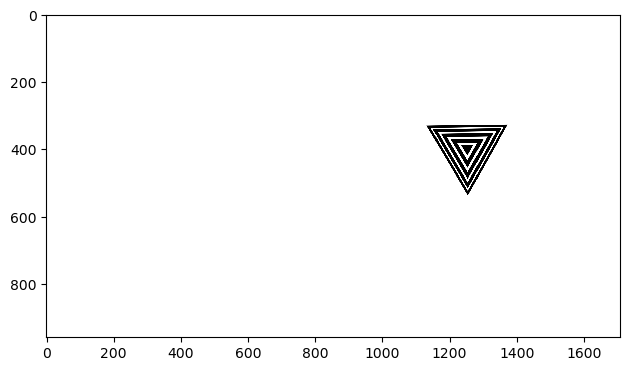

In [3]:
image = io.imread('Test Images/test1.png', as_gray=True)
io.imshow(image)
image.shape

Load the sticker

(332, 376)


Text(0.5, 1.0, 'Sticker in Frequency Domain')

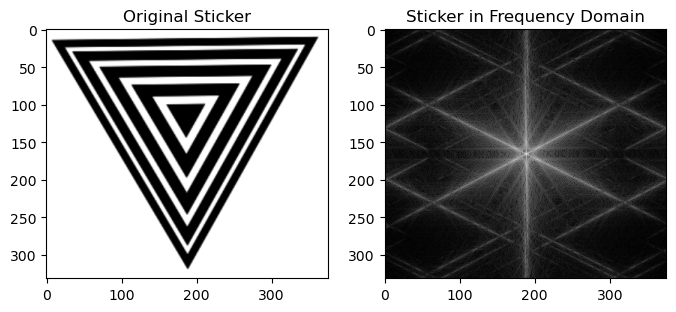

In [9]:
# Convert from rgba to gray
sticker = io.imread('stickers/triangle.png', as_gray = True)
print(sticker.shape)
# apply dft on sticker image
dft_sticker = h.get_dft(sticker)
dft_sticker = h.get_dft_magnitude(dft_sticker)
# Plot the sticker in both spatial and frequency domains
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(sticker, cmap='gray')
ax1.set_title("Original Sticker")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(dft_sticker,  cmap='gray')
ax2.set_title("Sticker in Frequency Domain")

Divide the image into equal sized boxes

- Since the sticker has shape (332,376), we pad the image and divide it into boxes of the same size (332,376).

- The **show_grid** function helps pad the image so that it is evenly divisible by (332,376), and then draws vertical and horizontal lines to show the boxes.

Size of the padded image is: (996, 1880)


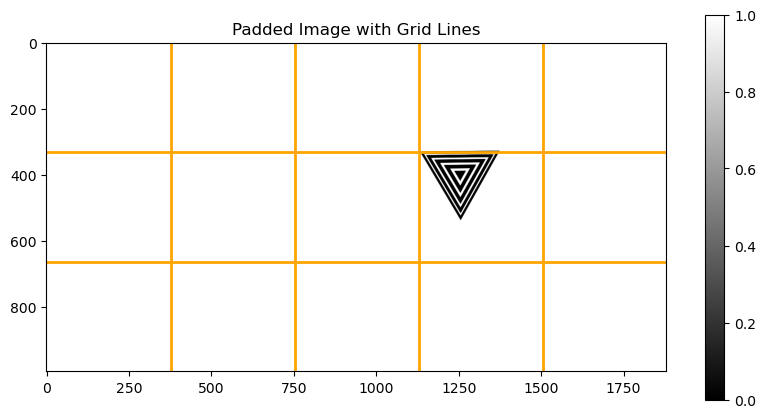

In [26]:
box_height, box_width, padded_image = h.pad_image(sticker, image, mode = 'constant')
print(f'Size of the padded image is: {padded_image.shape}')
# the show_grid function has already padded the image
h.show_grid(sticker, image)


- Here, the original image is padded into the new shape (996,1080) evenly divisible by the sticker. The orange grid lines show how the image is divided. There are 3*5=15 boxes.

Perform FFT on every box, and combine them all together

- The **create_spectrogram** function computes the FFT of every box and combine them together
- The **show_spectrogram** function display the resulting spectrogram of the image.
    - If "grid = True", then the grid lines can be displayed.

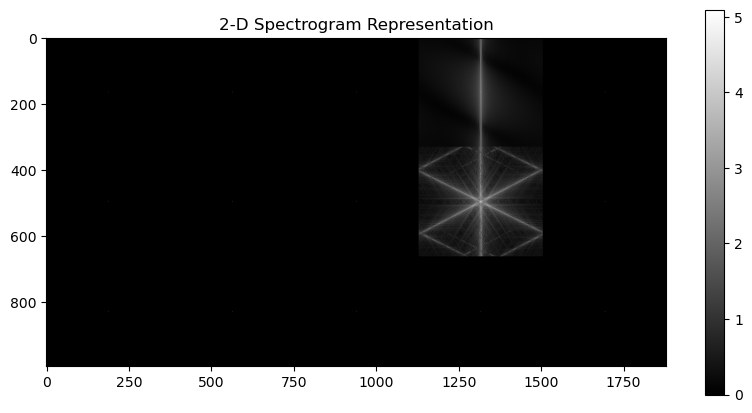

In [7]:
composite_dft = h.create_spectrogram(sticker,image)
h.show_spectrogram(composite_dft, sticker, grid = False)

- Now we have created a 2D spectrorgam for an image! The frequency information of the triangle sticker can be clearly seen from the spectrogram. Displaying the results for sequences of images, we will get the videos of 2D Spectrograms. 

### Algorithm 1: Non-overlapping Grid Search

Inspired by the result of 2D spectrogram, we next explore whether it would be possible to track objects in frequency domain. The first searching algortithm we developed is called Non-overlapping Grid Search.

- Input: image, sticker
- Output: the detected box location of the object in the image

**Steps:**
1. Divide the image into non-overlapping search boxes with the same size as the sticker
2. Compare the MSE between the sticker and each search box in frequency domain, find the one with minimum value of MSE.
3. Return the index number of the box.

Instead of the simplist white background, we now add some Perlin noise to the image to see whether the algorithm could still perform well on low frequency noisy background.

#### Demonstration

##### (1) Object within the boxes

Load the image with Perlin noise

(960, 1708)

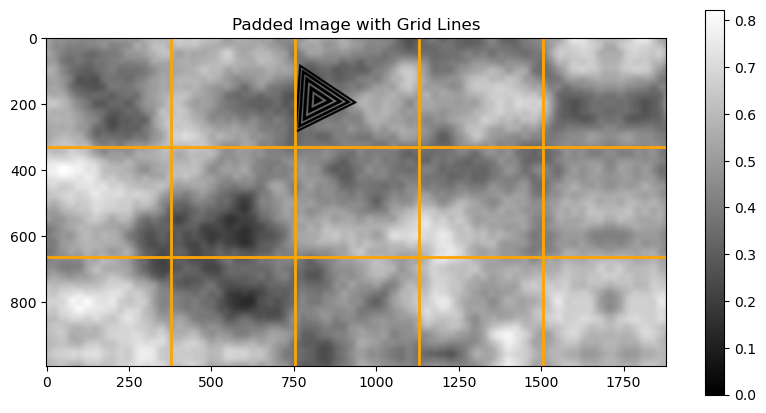

In [14]:
image2 = io.imread('Test Images/test2.png', as_gray=True)
h.show_grid(sticker, image2, padding_mode = "reflect")
image2.shape

The **find_location_mse** function iterates over each box and compare their MSE with the sticker in frequency domain. 

- It returns the box number with minimal MSE, the minimal value of MSE, the sorted MSE values for all boxes and their indexes.

In [13]:
best_box,min_mse, sorted_box_idx, sorted_mse = h.find_location_mse(sticker,image2)
print(f'Best Search Box: {best_box}')
print(f'Minimum value of MSE: {min_mse}')

Best Search Box: 3
Minimum value of MSE: 0.2766207765512889


- Here, our algorithm can correctly predict the location of the target box, which is the 3th box and has minimum MSE 0.28.

- The adding of Perlin Noise in the background does not affect the tracking accuracy.

##### (2) Object between two boxes

- Inevitably, the object might exist between two or more boxes, and our algorithm is able to detect the box location that contains part of the object.

(960, 1708)


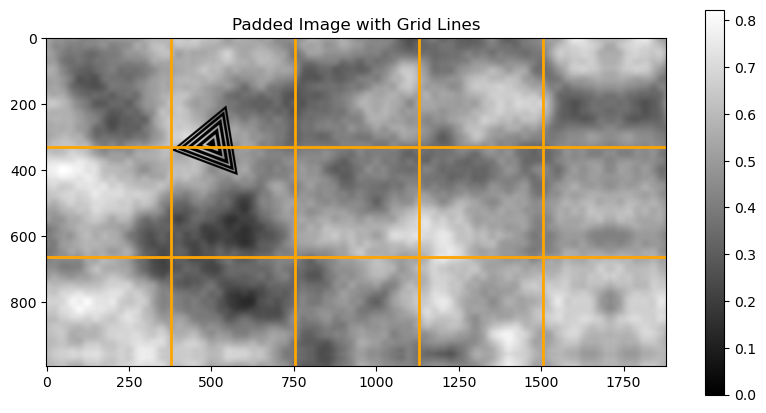

In [42]:
image3 = io.imread('Test Images/test3.png', as_gray=True)
print(image3.shape)
h.show_grid(sticker, image3, padding_mode = 'reflect')

In [43]:
best_box, min_mse, sorted_box_idx, sorted_mse = h.find_location_mse(sticker,image3)
print(f'Best Search Box: {best_box}')
print(f'Minimum value of MSE: {min_mse}')
print(sorted_mse)
print(sorted_box_idx)

Best Search Box: 7
Minimum value of MSE: 0.22969897112790896
[0.22969897 0.24355343 0.30087037 0.37337531 0.39806222 0.40038912
 0.40250065 0.40338619 0.41604833 0.42040486 0.43279719 0.43620555
 0.43695415 0.43735583 0.43939014]
[7, 2, 15, 12, 3, 4, 6, 14, 5, 11, 13, 10, 8, 1, 9]


- Here, the target object exists in the 2th and 7th boxes, and our algorithm can detect the 7th box which contain part of the object. 

- The adding of Perlin Noise in the background does not affect the tracking accuracy.

- Moreover, the object is actually in both the 2th and 7th box. When printing the result of sorted box numbers with ascending MSEs, we find that the 2th and 7th boxes indeed have the minimum values of MSE. For further improvement, we could let our algorithm not only consider the box with minimum MSE, but several boxes with small MSEs.

### Algorithm 2: Overlapping Grid Search

To better detect objects between boxes, we improve our algorithm to search through overlapping boxes. Specifically, the algorithm allows for manually setting the searching steps in both horizontal and vertical direction, which controls the accuracy of search as well as efficiency.

- Input: image, sticker

- Output: the detected location of object in the image

**Parameters:**
- x_step: how many pixels the search box moves horizontally every time
- y_step: how many pixels the search box moves vertically every time

#### Demonstration

Load the image:

(960, 1708)


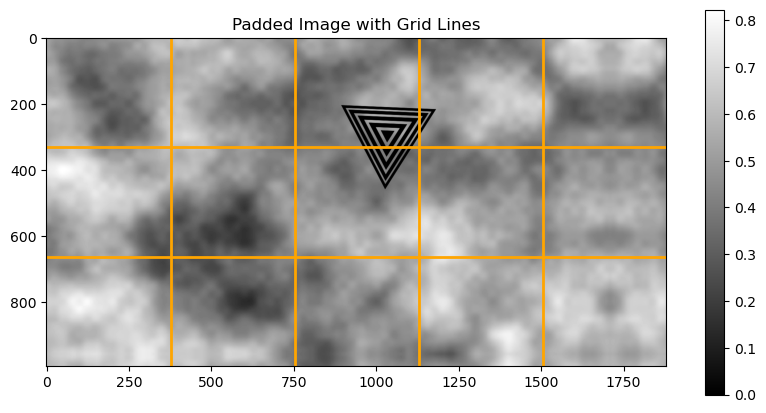

In [18]:
image4 = io.imread('Test Images/test4.png', as_gray=True)
print(image4.shape)
h.show_grid(sticker, image4, padding_mode="reflect")

The **find_location_sliding_window** function find the best location of the searching box by sliding it over the image in the given steps.

- The parameters **x_step** specifies how many pixels the search box moves horizontally every time, and **y_step** specifies how many pixels the search box moves vertically every time.

- The function returns the top left coordinate of the best search box, and the image within that box.

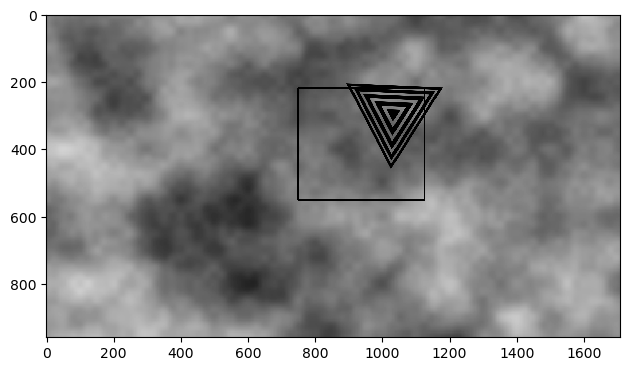

In [19]:
best_position, best_match_box = h.find_location_sliding_window(sticker, image4, x_step = 150, y_step = 20)
h.draw_bounding_box(sticker,image4, best_position)

- Here, our overlapping algorithm can capture most of the object. Smaller steps may yield better tacking accuracy but also less efficiency.

### Algorithm 3: Recursive Grid Search

From our previous two searching algorithms, the size of the searching box is fixed since it has to match the size of the sticker. To make the searching size more flexible so that we could track objects with varying sizes, we develop a new algorithm that does not require searching box to have a fixed size. 

- Input: image, sticker, bound (top left and bottom right position of the image)

- Output: the location of the detected object

**Steps:**
1. Divide the image into four equal parts, where each part is a searching area.
2. Resize the sticker in frequency domain to fit the size of the searching area, and compute their MSE in frequency domain. 
3. Find the searching area with minimum MSE, then recursively search that area until the area is smaller than the original size of the sticker.
4. Return the area with minimum MSE.

#### Demonstration

Load the image

(960, 1708)


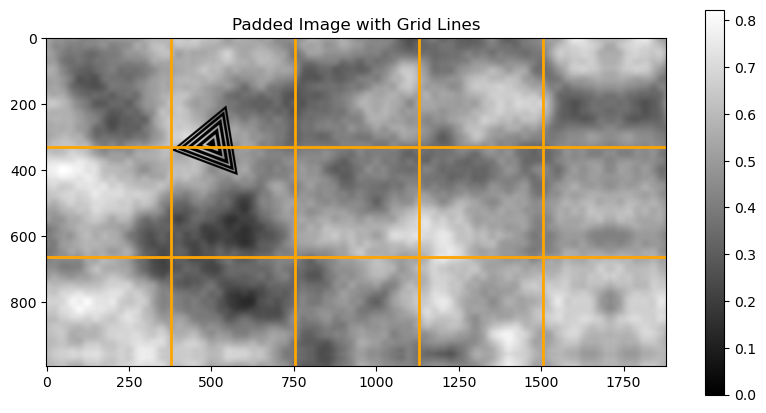

In [20]:
image3 = io.imread('Test Images/test3.png', as_gray=True)
print(image3.shape)
h.show_grid(sticker, image3, padding_mode="reflect")

The function **find_location_mse** divides the image into 4 parts and recursively find the best searching area until the area is smaller than the sticker size.

- It returns top left coordinate of the best searching area and the image within it.

The **draw_bounding_box** function draw the bounding box of the best location based on the box size and the top left coordinate of the searching area.

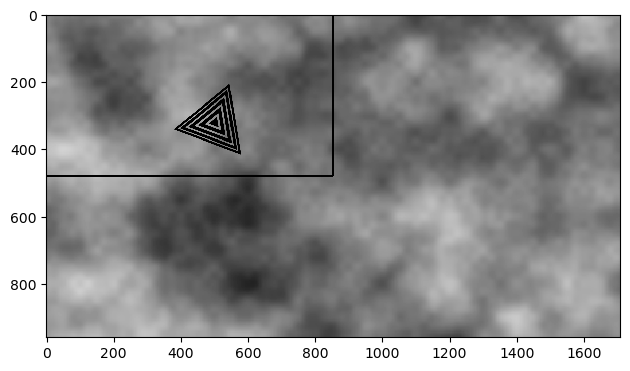

In [21]:
# Predefine the top left and bottom right location of the image 
bound = (0, 0, image3.shape[0], image3.shape[1])
selected_part, selected_bounds = h.find_location_recursive(sticker, image3, bound)
# We only need the top left location of the target area to draw bounding box
y,x,_,_ = selected_bounds
h.draw_bounding_box(selected_part, image3, (y,x))

- Here, our recursive algorithm can successfully capture the object. The algorithm is pretty efficient due to recursion, but, as shown in the result, the bounding box might be significantly larger than the target object. This is probably because the algorithm prioritize tracking accuracy over tracking region. 

- In addition, the algorithm can perform well when the moving object is also changing in sizes -- which we later tested in our real life videos.

## Results

In the Results section of our presentation, we showcase the effectiveness and practical applications of our developed algorithms for tracking high-frequency objects in real-life scenarios through detailed videos and analytical comparisons. Here's how our final application performs, demonstrated through specific examples and a comparative analysis:

### Videos of 2D Spectrograms

   We begin by displaying videos that illustrate the creation and dynamic changes of 2D spectrograms as high-frequency objects move through various scenes. These videos highlight the ability of our spectrograms to capture and visualize frequency-based movements, providing a clear and immediate understanding of object locations and trajectories in the frequency domain.

   We developed the function [view_spectrogram](view_spectrogram.py) to generate the spectrogram videos.

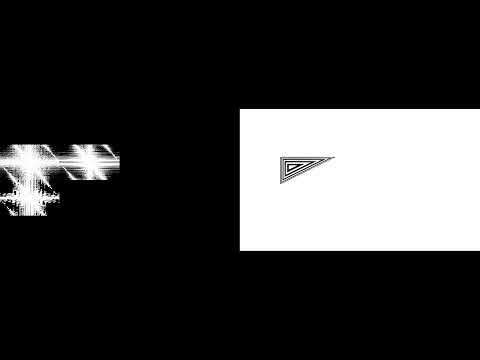

In [30]:
video_id = "jWLm6j1cS-s"
display(YouTubeVideo(video_id))

- In this video, we show the dynamic spectrogram representation of a triangular sticker against a white background. The video is split into two sections for comparative observation. On the left, you see the spectrogram we constructed; on the right, the corresponding original video frame is displayed.

- As we progress through the frames, you'll notice the distinct frequency characteristics of the triangular sticker clearly mirrored in both the spectrogram and the original image. The spectrogram vividly highlights these features, distinguishing them from the uniform white background, which primarily exhibits minimal frequency variations (appearing near zero). This visualization helps in understanding how different objects manifest in the frequency domain and their distinct characteristics compared to uniform backgrounds.

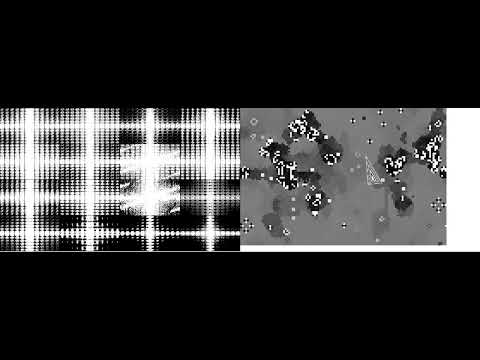

In [31]:
video_id = "utpXXf6dEBk"
display(YouTubeVideo(video_id))

- In this video, we show the dynamic spectrogram representation of the same triangular sticker but against a moving noisy background. Same as before, on the left, you see the spectrogram we constructed; on the right, the corresponding original video frame is displayed.

- As we progress through the frames, you'll notice even though the background is noised, the distinct high frequency characteristics of the triangular sticker is still clearly mirrored in both the spectrogram and the original image. The difference between the backgroud frequency and the sticker frequency can be visually identified.

### Algorithm 1 (Non-overlapping Grid Search)
This section of our presentation showcases the efficacy of the Non-overlapping Grid Search algorithm when applied to real-life video footage. In the demonstration, you will see a prerecorded YouTube video that illustrates the object tracking capabilities of our algorithm. The video highlights how the algorithm segments the video into grids and adeptly tracks a high-frequency sticker, ensuring that search areas do not overlap, thus optimizing the tracking accuracy.

While we are unable to embed side-by-side framewise comparisons from our 'test_sliding_window_nonoverlap.py' directly here (you can check the original file in our repo), the video provides a comprehensive view of how the algorithm performs in real-world scenarios, capturing the dynamic movements of the target object with high precision.

We developed the function [test_sliding_window_nonoverlap](<Testing Algorithms/test_sliding_window_nonoverlap.py>) to generate the video.

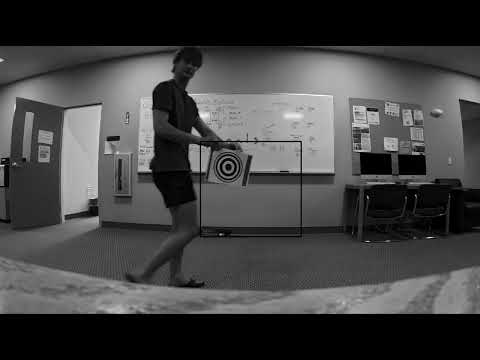

In [32]:
video_id = "d-iT8dwB0Ag"
display(YouTubeVideo(video_id))

- We can see from the video that generally the searching box we located can correctly capture the targeted sticker. However, there are some random detection errors throughout the video.\
- Another thing to be noted here is that the size of the searching box is fixed, because we are using the size of the original sticker as the size of the searching box entire time.

### Algorithm 2 (Overlapping Grid Search)

This segment demonstrates the Overlapping Grid Search algorithm, where increasing the overlap between search grids significantly enhances tracking accuracy. This approach proves particularly effective in complex scenes with unpredictable object movements. You could check out the side-by-side framewise comparisons in the file 'test_sliding_window_overlap.py'. The linked YouTube video showcases the algorithm's robustness. It highlights how the algorithm maintains tracking continuity over successive frames, thus significantly improving detection accuracy and reducing random detection errors.

We developed the function [test_sliding_window_overlap](<Testing Algorithms/test_sliding_window_overlap.py>) to generate the video.

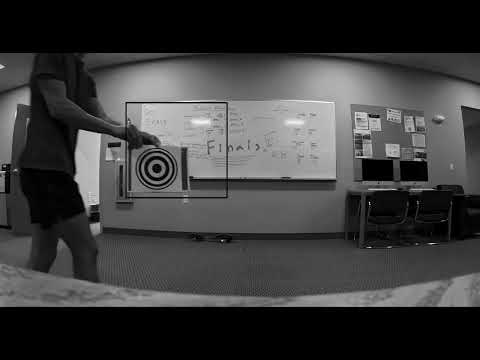

In [33]:
video_id = "oHoC-3dHfG8"
display(YouTubeVideo(video_id))

- We are using step=100 here. We can see from the video that the random errors are significantly reduced from the non-overlapping grid search, while the size of the searching box is still fixed.

### Algorithm 3 (Recursive Grid Search)

This segment delves into the Recursive Grid Search algorithm, which employs a sophisticated approach by recursively dividing the search area into 4 equal subareas. This method enhances focus on regions with significant high-frequency content, allowing for precise zooming and highly detailed tracking of the target object. The side-by-side framewise comparison of original footage against processed outputs is implemented in our 'test_recursive_search.py' file. The linked YouTube video vividly illustrates the algorithm's efficacy.

We developed the function [test_recursive_search](<Testing Algorithms/test_recursive_search.py>) to generate the video.

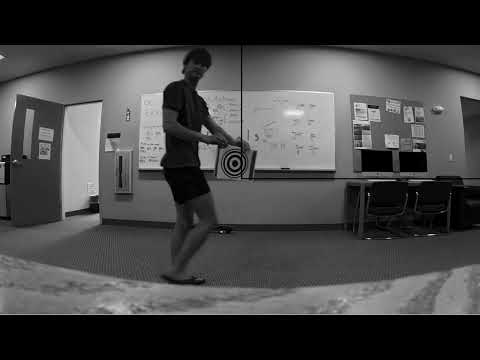

In [34]:
video_id = "5xcFcmFl6LU"
display(YouTubeVideo(video_id))

We can see the recursive grid search method can generally capture the target sticker. However, the accuracy is hard to determine since the size of the box is bouncing due to the nature of recursive search.

### Comparative Analysis

The culmination of our results section is a comprehensive comparison of all three algorithms against a standard template matching technique. We provide a graph plotting Accuracy versus Running Time, illustrating each algorithm's performance trade-offs. This comparison not only highlights the superior speed and accuracy of our methods but also their effectiveness in different operational contexts.

- **Accuracy v.s. Running Time**: This graph serves as a critical analytical tool, showing that our algorithms, particularly the Overlapping and Recursive Grid Searches, achieve high accuracy while maintaining reasonable computation times, suitable for real-time applications.

- **Run-Time**: We record the runtime of each algorithm by record the exact time it takes for each algorithm to run on one specific frame.

- **Accuracy**: We calculate the accuracy of each algorithm by running each algorithm on the same set of 180 frames and manually counted in how many frames the algorithm detects the target sticker correctly. Then we divide that number by 180 to find the accuracy rate.

Here is the graph visualization:

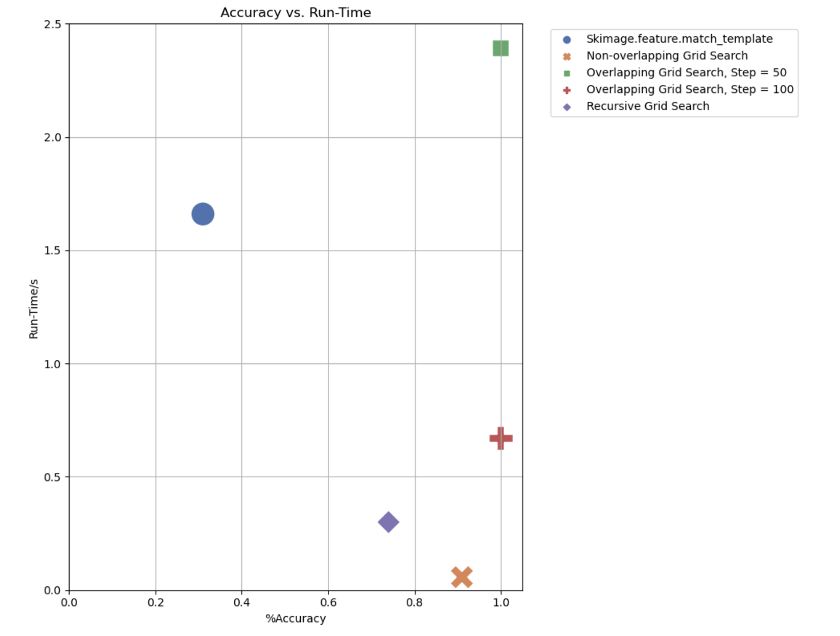

In [36]:
# Display an image by directly specifying the path
display(Image(filename='runtime&accuracy.png', width=1000, height=500))

- The graph clearly illustrates that the match_template algorithm from skimage yields low accuracy and a relatively high runtime. This inefficacy arises because the template matching algorithm lacks scale invariance. As the size of the target sticker varies throughout the video, maintaining a fixed template size hampers the algorithm's effectiveness.

- In contrast, the overlapping grid search algorithm achieves the highest accuracy, hitting a perfect 100%. However, despite the ability to adjust the step parameter to balance accuracy and runtime, the runtime remains considerably higher compared to the other algorithms we developed.

- Both the non-overlapping grid search and the recursive grid search exhibit high accuracy with minimal runtime. Among these, the non-overlapping grid search slightly edges out with better accuracy and reduced runtime.

- Overall, our algorithms demonstrate robust scale-invariant and rotation-invariant object tracking capabilities by leveraging frequency information.

### Extend to Compare with SIFT

When considering scale invariance, SIFT naturally comes to mind. Therefore, we delved further into evaluating how SIFT performs in our object tracking scenarios.

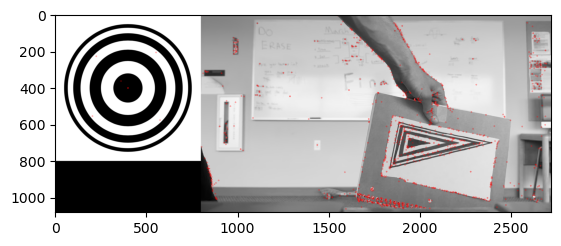

(<matplotlib.image.AxesImage at 0x1483eb690>, None)

In [38]:
# Read the main image and the template
img = cv.imread('Test Images/template_img.png', cv.IMREAD_GRAYSCALE)
template = cv.imread('stickers/circle_sticker.png', cv.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv.SIFT_create()

# Find keypoints and descriptors with SIFT
keypoints_1, descriptors_1 = sift.detectAndCompute(template, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img, None)

# Create matches using the FLANN matcher
index_params = dict(algorithm = 1, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# Ratio test as per Lowe's paper
for i, (m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)

img3 = cv.drawMatchesKnn(template, keypoints_1, img, keypoints_2, matches, None, **draw_params)

plt.imshow(img3), plt.show()


- For the circular sticker, SIFT performs poorly, failing to identify sufficient feature points. Consequently, it struggles to effectively detect the sticker in our video.

## Accessibility

#### Current Accessibility Features:
- Visual Design:
  - We keep the images and videos black and white to ensure high contrast to accommodate users with visual impairments.

#### Areas for Improvement:
- Educational Barrier:
  - Understanding our algorithms requires proficiency with Python and concepts like fourier transform, object detection/tracking.
  - We could offer recommended online tutorial links to assist people who want to use our algorithms.
- Screen Reader Compatibility:
  - Provide alt text for images and diagrams and ensure that all elements are properly labeled to be descriptive when read by screen readers.
  - Enhance screen reader support by adding ARIA labels to interactive elements, especially in dynamic content like spectrogram visualizations.



## Ethical Implications

- **Educational Impact**: By providing a tool that can accurately track and analyze high-frequency changes in images, our project can serve as an educational platform in academic settings. It can help students and researchers understand the dynamics of physical processes captured in images, such as movement patterns in biological specimens or material deformations under stress.

- **Accuracy and Reliability**: For researchers and academia, the precision and reliability of experimental results are paramount. If our algorithm introduces any bias or inaccuracies, it can lead to incorrect conclusions, affecting the validity of research outcomes. It's crucial that the algorithm is thoroughly validated across various scenarios to ensure its reliability. There is also the issue of accountability in the case where our algorithm fails or otherwise leads to detrimental consequences. Our results are preliminary and do not warrant wide usage for sensitive tasks.

- **Privacy Concerns**: While not directly applicable to all research scenarios, if any part of the study involves human subjects or sensitive biological data, there are significant privacy considerations. It's important to ensure that all data, particularly personal or sensitive information, is handled and stored securely to comply with ethical standards and privacy laws.




## Schedule

##### **Original Schedule**

Week 1: 
- Make 2D videos with a moving high-frequency sticker and a constant bright background
- Develop non-overlapping grid search algorithm

Week 2-3:
- Define and Visualize 2D spectrogram
- Explore the effects of different motions (rotation, translation) on spectrogram representations.

Week 4-5: 
- Interpret and Explore the Applications of 2-D Spectrogram
Work on real-life videos

##### **Actual Schedule**

Week 1: 
- Explore different frequency spaces (DCT, DST, FFT, Wavelet,...)
- Develop non-overlapping grid search algorithm
- Create stickers and videos for the algorithm

Week 2-3:
- Create 2D spectrogram on different backgrounds
- Try different evaluation metrics: MSE, SSIM, etc
- Explore the effects of different motions and backgrounds on detection accuracy

Week 4-5: 
- Developed two other algorithms: overlapping grid search and recursive search
- Test our algorithms  on real-life videos. Compare their accuracy and efficiency in tracking.
- Detect rotation of the stickers in frequency domain 

Comparing our original schedule and actual schedule, we mostly followed our original plan and made some slight modifications:

- In Week 1, we spent some time deciding which frequency space to choose, and tested DCT, DST, FFT, Wavelet on images. We ended up choosing the FFT because it captures phase information and can better handle images with complex high frequency components. We also created different high frequency stickers and videos with moving objects (stickers) and different backgrounds.

- In Week 2-3, we were deciding which evaluation metric to choose for our opmitization step. This was not anticipated in our original schedule.

- In Week 4-5, we noticed that our first algorithm -- Non-overlapping Grid Search -- cannot perform well when objects are in between the boxes and when they vary in sizes. Therefore, we decided to developed the other two algoritms that could possibly help addressing these problems. To explore the application of our algorithm in real life scenarios, we recorded real life videos and tested our algorithms on them, comparing their accuracy and efficiency.

## Issues

## Future Work

## References